#Install Libraries

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
 return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers torch torchvision scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

#Import libraries

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from collections import Counter
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn. ensemble import RandomForestClassifier
import pickle
from sklearn.utils import class_weight
from shutil import rmtree

#Visualization the image-predicted_label and grouth_truth

In [ ]:
class_names = ['Fall', 'Not Fall']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_images(images, y_pred, y_true, n=5):
    # Randomly select n samples from the dataset.
    indices = random.sample(range(len(images)), n)

    # Number of columns and number of rows
    cols = 4
    rows = (n + cols - 1) // cols

    # Create a figure with rows rows and cols columns
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 3))

    # If there are fewer images than the number of columns, special handling is needed.
    axes = axes.flatten()  # Convert the axes array to 1D for easier iteration.

    for i, idx in enumerate(indices):
        ax = axes[i]

        # Display the label in green.
        ax.text(0.5, 1.15, f'True: {class_names[int(y_true[idx])]}', color='green', fontsize=12, ha='center', transform=ax.transAxes)

        # Display the predicted results in red if they differ from label.
        pred_color = 'red' if y_pred[idx] != y_true[idx] else 'green'
        ax.text(0.5, 1.05, f'Predicted: {class_names[int(y_pred[idx])]}', color=pred_color, fontsize=12, ha='center', transform=ax.transAxes)

        # Display image
        ax.imshow(cv2.cvtColor(images[idx],cv2.COLOR_BGR2RGB))
        ax.axis('off')  # Turn off axis display

    # Hide unused axes if the number of images is not enough to fill the entire figure.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

#Load dataset

In [ ]:
main_dir = './dataset'

imges_dir = os.path.join(main_dir, 'images')
labels_dir = os.path.join(main_dir, 'labels')

name_img_files = os.listdir(imges_dir)
name_label_files = os.listdir(labels_dir)

name_img_files.sort()
name_label_files.sort()

In [ ]:
def get_most_common_size_with_threshold(sizes,threshold = 0.25):
  # Find the most common size.
  size_counts = Counter(sizes)
  total_images = len(sizes)
  most_common_size = max(size_counts, key=size_counts.get)
  if size_counts[most_common_size] / total_images < threshold:
    most_common_size = None
  return most_common_size

In [ ]:
def get_aspect_ratio(width, height):
    return width / height

def get_average_size_with_aspect_ratio(widths,heights):
  average_width = int(np.mean(widths))
  average_height = int(np.mean(heights))

  # Find the most common aspect ratio.
  aspect_ratios = [get_aspect_ratio(w, h) for w, h in zip(widths, heights)]
  most_common_aspect_ratio = Counter(aspect_ratios).most_common(1)[0][0]

  # Compute the new dimensions based on the most common aspect ratio.
  if get_aspect_ratio(average_width, average_height) != most_common_aspect_ratio:
      average_height = int(average_width / most_common_aspect_ratio)

  return (average_width, average_height)



In [ ]:
def get_suitable_size(sizes,widths,heights,threshold = 0.25):
  # Find the most common size.
  most_common_size = get_most_common_size_with_threshold(sizes,threshold)
  if most_common_size is None:
    most_common_size = get_average_size_with_aspect_ratio(widths,heights)
  return most_common_size

In [ ]:
def custom_ceil(value):
    fractional_part = value - np.floor(value)
    if fractional_part > 0.5:
        return np.ceil(value)
    else:
        return np.floor(value)

def resize_to_nearest_power_of_two(image_size, min_dimension=7):
    width, height = image_size

    new_width = min_dimension * 2**custom_ceil(np.log2(width / min_dimension))
    new_height = min_dimension * 2**custom_ceil(np.log2(height / min_dimension))

    new_width = int(new_width)
    new_height = int(new_height)

    return (new_width,new_height)

In [ ]:
def resize_image(images, size):
    resized_images = []
    for image in images:
        resized_images.append(cv2.resize(image, size))
    return resized_images

Sử dụng Image_dataset_from_directory tiết kiệm dung lượng

In [ ]:
import os
import cv2
import tensorflow as tf
from shutil import rmtree

def save_image_to_directory(img, label, output_dir, img_name):
    global class_names
    # Create the label directory if it doesn't exist
    label_dir = os.path.join(output_dir, str(class_names[label]))
    os.makedirs(label_dir, exist_ok=True)

    # Save the image in the corresponding label directory
    img_path = os.path.join(label_dir, img_name)
    cv2.imwrite(img_path, img)

def create_data_label(images_dir, labels_dir, images_files, labels_files, folder='train', threshold=0.25, is_fall_value=0, output_dir='output'):
    os.makedirs(output_dir, exist_ok=True)
    # if os.path.exists(output_dir):
    #     rmtree(output_dir)

    face_img_sizes = []
    face_img_heights = []
    face_img_widths = []
    num_faces = 0

    for count, images_file in enumerate(images_files):
        if images_file.endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp')):
            image_path = os.path.join(images_dir, folder, images_file) if folder is not None else os.path.join(images_dir, images_file)
            img = cv2.imread(image_path)
            if img is not None:
                # Read the corresponding label file
                label_path = os.path.join(labels_dir, folder, labels_files[count]) if folder is not None else os.path.join(labels_dir, labels_files[count])
                with open(label_path, 'r') as file:
                    r = file.readlines()

                bounding_boxes = []
                for values in r:
                    value = values.split()
                    bounding_boxes.append([int(value[0]), float(value[1]), float(value[2]), float(value[3]), float(value[4])])

                for box in bounding_boxes:
                    image_height, image_width, channels = img.shape

                    # Get bounding box of the element (person)
                    x_min = int(box[1] * image_width)
                    y_min = int(box[2] * image_height)
                    box_width = int(box[3] * image_width)
                    box_height = int(box[4] * image_height)

                    # Calculate crop limits (ensure not to exceed image boundaries).
                    x_start = max(0, x_min - box_width // 2)
                    y_start = max(0, y_min - box_height // 2)
                    x_end = min(image_width, x_min + box_width // 2)
                    y_end = min(image_height, y_min + box_height // 2)

                    # Crop the image to get the element
                    cropped_img = img[y_start:y_end, x_start:x_end]
                    if cropped_img is not None and cropped_img.shape[0] > 0 and cropped_img.shape[1] > 0:
                        label = int(box[0] != is_fall_value)
                        # Save the cropped image into the appropriate folder
                        save_image_to_directory(cropped_img, label, output_dir, f"{images_file}_cropped_{count}.jpg")

                        # Track face sizes for determining suitable size
                        height_face, width_face, _ = cropped_img.shape
                        face_img_sizes.append((width_face, height_face))
                        face_img_widths.append(width_face)
                        face_img_heights.append(height_face)
                        num_faces += 1

    if num_faces == 0:
        raise ValueError("No images found in the specified directory or the number of labels and images isn't the same.")
    return get_suitable_size(face_img_sizes, face_img_widths, face_img_heights, threshold)

In [ ]:
suitable_size = create_data_label(imges_dir,labels_dir,name_img_files,name_label_files,folder = None,is_fall_value = -1,output_dir = './dataset_tensorflow')

In [ ]:
resize_to_nearest_power_of_two((214, 428),7)

(224, 448)

#Evaluation model

In [ ]:
def evaluation_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)

  print("Classification Report:")
  print(classification_report(y_true, y_pred))

  conf_mat = confusion_matrix(y_true, y_pred)
  displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  displ.plot()

#Model

##Deep Learning

###Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers as L
import keras
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Rescaling
from tensorflow.keras.metrics import BinaryAccuracy, BinaryCrossentropy,categorical_crossentropy,categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.src.applications import imagenet_utils
from tensorflow.keras.applications import VGG16,MobileNetV2

In [ ]:
def compute_class_weights(y_train):
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return dict(enumerate(class_weights))

Dùng image_dataset_from_directory

In [ ]:
batch_size = 32
image_size = (448, 224)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset",
    validation_split=0.2,
    subset="training",
    label_mode='binary' ,
    #labels = n_classes,
    interpolation = "mitchellcubic",
    seed=42,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset",
    validation_split=0.2,
    subset="validation",
    label_mode='binary' ,
    #labels = n_classes,
    interpolation = "mitchellcubic",
    seed=42,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size
)

Found 48086 files belonging to 2 classes.
Using 38469 files for training.
Found 48086 files belonging to 2 classes.
Using 9617 files for validation.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Lấy nhãn từ dataset
labels = np.concatenate([y for x, y in train_ds], axis=0)



In [ ]:
labels = labels.ravel()

# Tính toán class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))



####MobileNet v2

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2

def create_mobilenet_2_model(input_shape, num_classes):
    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Define the input layer
    inputs = Input(shape=input_shape)

    # Add the Rescaling layer
    x = Rescaling(1. / 255)(inputs)

    # Add the base model
    x = base_model(x)

    # Add custom classification layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='mish')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='mish')(x)
    x = Dropout(0.5)(x)
    if num_classes == 2:
        x = Dense(1, activation='sigmoid')(x)  # Binary classification
    else:
        x = Dense(num_classes, activation='softmax')(x)  # Multi-class classification

    # Define the model
    model = Model(inputs=inputs, outputs=x)

    return model


In [ ]:
model_mobilenet2 = create_mobilenet_2_model(input_shape =  list(image_size)+[3], num_classes = len(class_names))
model_mobilenet2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1) if len(class_names) == 2 else tf.keras.losses.categorical_crossentropy(from_logits=True, label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
model_mobilenet2.summary()

<ipython-input-32-0d0921450882>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 448, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 448, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 14, 7, 1280)         │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,177,025 (12.12 MB)

 Trainable params: 919,041 (3.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_path="/content/best_check_point/{}_weights.best.keras".format('mobilenetv2')
callbacks = [
    ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-6, verbose=1),
    ModelCheckpoint(model_path, monitor='val_binary_accuracy', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = False),
    EarlyStopping(monitor='val_binary_accuracy',patience=6,verbose=1,mode='max',restore_best_weights = True)
]

In [ ]:
model_mobilenet2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1) if len(class_names) == 2 else tf.keras.losses.categorical_crossentropy(from_logits=True, label_smoothing=0.1),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
history_mobilenet2 = model_mobilenet2.fit(train_ds, validation_data=val_ds, verbose=1, epochs=5,class_weight =class_weights_dict,callbacks = callbacks)

In [ ]:
model_mobilenet2.save('model_mobilenet2.keras')

In [ ]:
y_pred_mobilenet2 = []
y_true = []

for images, labels in val_ds:
    preds = model_mobilenet2.predict(images, verbose=0)
    preds = tf.squeeze(preds)

    y_pred_mobilenet2.extend([1 if x >= 0.5 else 0 for x in preds])
    y_true.extend(labels.numpy())

y_pred_mobilenet2 = np.array(y_pred_mobilenet2)
y_true = np.array(y_true)

Accuracy: 0.9653738171987106
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      4614
         1.0       0.96      0.97      0.97      5003

    accuracy                           0.97      9617
   macro avg       0.97      0.96      0.97      9617
weighted avg       0.97      0.97      0.97      9617



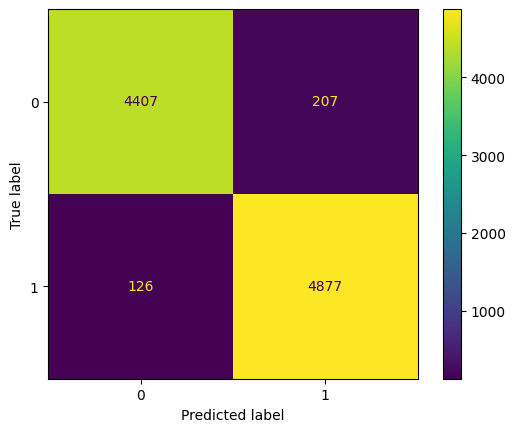

In [ ]:
evaluation_model(y_true, y_pred_mobilenet2)